####  library & environment

In [ ]:
library(Seurat)
library(ggplot2)
library(tidyr)
library(dplyr)
library(Hmisc)
library(openxlsx)
library(foreach)
library(doParallel)
library(AUCell)
library(ggpubr)

# rm(list = ls())
set.seed(2025)
colors <- c("E13.5" = "#a9d0f5", "E15.5" = "#e58b29",  "E13.5_ref" = "gray",
          "Vcl cKO"="#f82401", "Control" = "#0f7dbd", 
           "Neuroblast" = "#fdcee6",  "BranchA" = "#bca9f5")


colors <- c(
    "E13.5" = "#a9d0f5", 
    "E15.5" = "#e58b29",  
    "E13.5_ref" = "gray",
    
    "Vcl cKO"="#f82401", 
    "Control" = "#0f7dbd", 
    
    "BP" = "#6b853e",
    "Neuroblast" = "#fdcee6",  
    "BranchA" = "#bca9f5", 
    
    "E13.5_Neuroblast" = "#E41A1C",  
    "E15.5_Neuroblast" = "#FFED6F",  
    "E13.5_BranchA" = "#4DAF4A",  
    "E15.5_BranchA" = "#F5A9D0",
    "E13.5_BP" = "#819ff7",
    "E15.5_BP" = "#FAAC58"
   )

In [ ]:
objs <-readRDS(paste0("/final.annotated.obj.rds"))
objs <- JoinLayers(objs)
objs <- subset(objs, final.annotation %in% c('BranchA','Neuroblast',"BP"))

######## set same number of cells

metadata <- objs@meta.data
metadata$barcode <- rownames(metadata)

cells <- list()
for(stag in unique(metadata$stage)){ 
    metadata.sub <- subset(metadata, stage == stag)
    for(celltype in unique(metadata.sub$final.annotation)){
        num <- table(metadata.sub[metadata.sub$final.annotation == celltype,c("group")]) %>% min()
        cell <- c(sample(metadata.sub[metadata.sub$group == "Control" & metadata.sub$final.annotation == celltype, "barcode"], num), 
                 sample(metadata.sub[metadata.sub$group == "Vcl cKO" & metadata.sub$final.annotation == celltype, "barcode"], num))
        cells[[paste0(stag, celltype)]] <- c(cell)

    }
}

# table(metadata[unlist(cells),c("final.annotation", "group", "stage")])
# table(metadata[,c("final.annotation", "group", "stage")])

obj <- objs[,unlist(cells)]
metadata <- obj@meta.data
table(metadata[,c("final.annotation", "group", "stage")])

#### PCA 

Normalizing layer: counts

Finding variable features for layer counts

PC_ 1 
Positive:  Top2a, Cdk1, Hmga2, Ednrb, Ccnd1, Sox2ot, Mef2c, Aurkb, Adam12, Spc25 
	   Fbxo5, H2afx, Kif15, Sntb1, Etl4, Ube2c, Ltbp1, Prc1, Ccnb1, Clspn 
	   Atad2, Tpx2, Mki67, Cenpe, Fabp7, Diaph3, Col25a1, Hmgn2, Sgo1, Kif11 
Negative:  Ntng1, Fam155a, Ctnna2, Nav3, Nrxn1, Stmn3, Pcdh15, Rtn1, Gng3, Mapt 
	   Gnao1, Ank2, Kcnt2, Xkr4, Fstl5, Hs6st3, Ncam2, Khdrbs2, Rab6b, Scn3a 
	   Ank3, Mapk10, Nrg3, Kctd12, Mllt11, Hecw1, Kcnip4, Sgcz, Tagln3, Slit2 
PC_ 2 
Positive:  Hist1h2ae, Hist1h2ab, Hist1h2an, Hist2h2ac, Hist2h2bb, Hist1h4h, Hist1h2bn, Hist1h3c, Hist1h1d, Hist1h3b 
	   Hist1h1a, Hist1h2be, Hist1h4c, Hist1h2bm, Hist1h2bb, Hist1h4k, Mki67, Kif11, Top2a, Prc1 
	   Hist1h4a, Hist1h2ai, Hist1h2br, Kif18a, Kif15, Diaph3, Il1rapl1, Atad2, Kif4, Kif20b 
Negative:  Tubb3, Tagln3, Tubb2b, Gal, Srrm4, Ifitm2, Meg3, Cck, Crmp1, St18 
	   Igfbpl1, Slc10a4, Elavl4, Grina, Phox2a, Actb, Mllt11, Nnat, Nefl, Hmx3

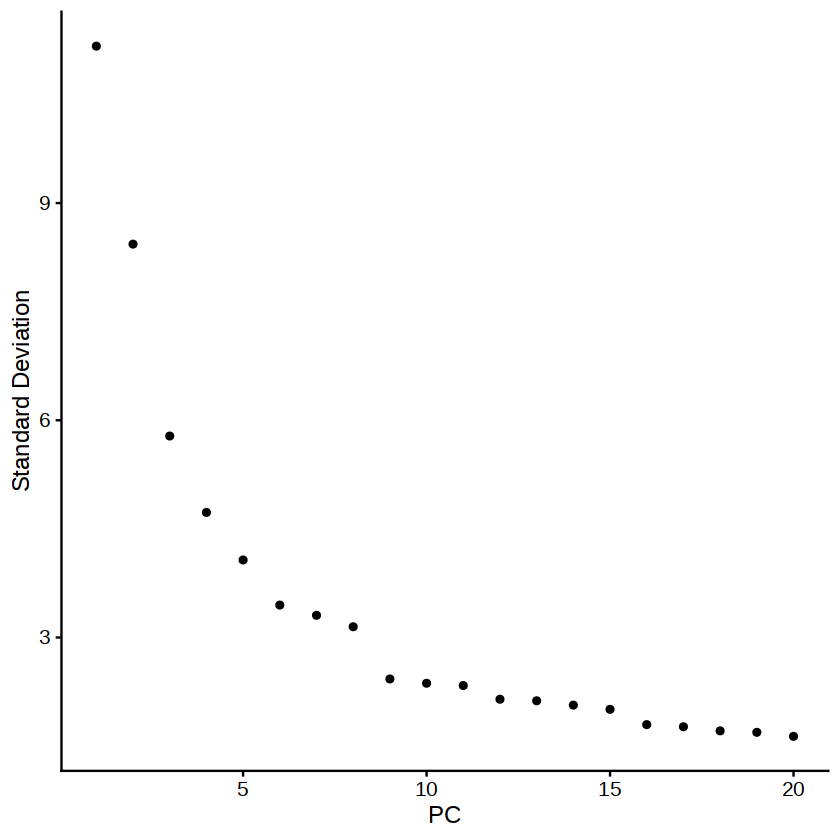

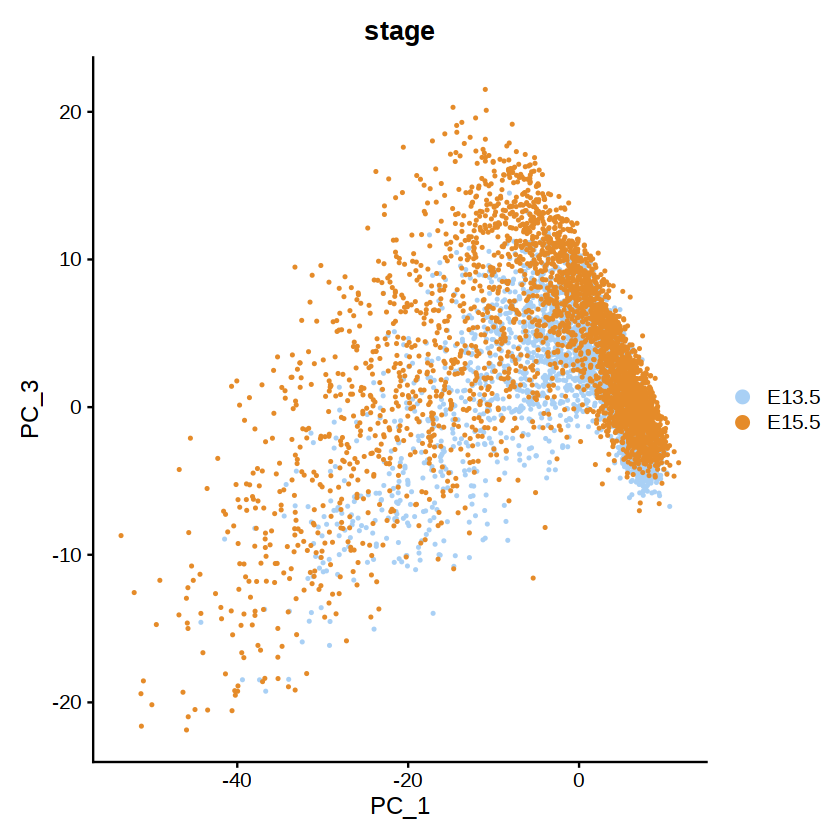

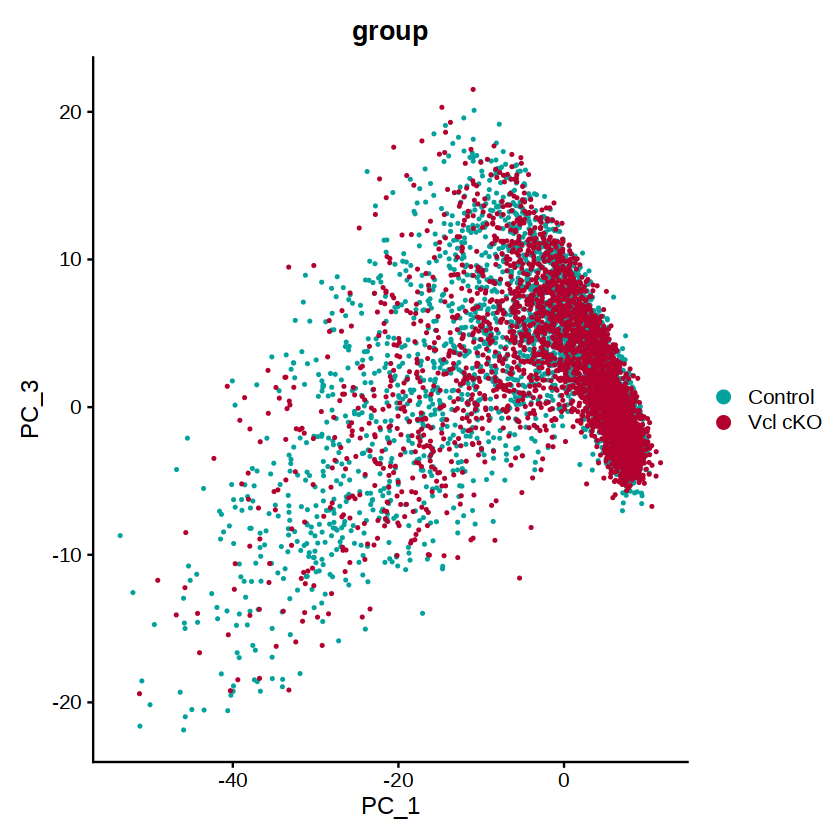

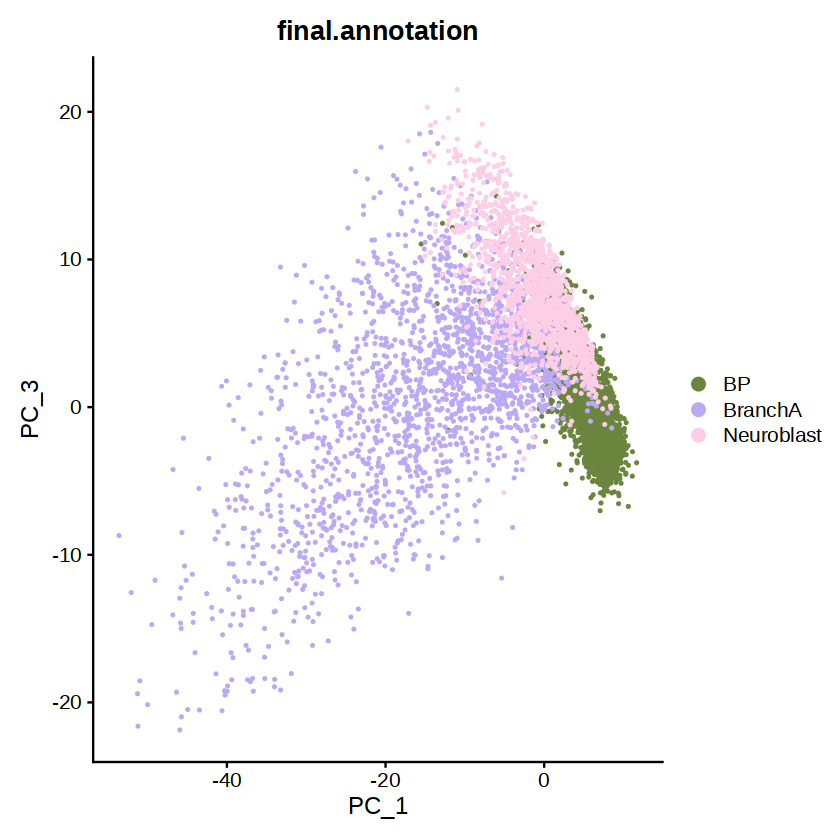

In [9]:
obj <- NormalizeData(obj)
obj <- FindVariableFeatures(obj, nfeatures = 3000)
obj <- RunPCA(obj,npcs = 30)
ElbowPlot(obj)
# options(repr.plot.width = 6, repr.plot.height = 5)

dims <- c(1,3)
DimPlot(obj, reduction = "pca", group.by = "stage", cols = colors, order = T, dims = dims)
DimPlot(obj, reduction = "pca", group.by = "group", cols = colors, order = T, dims = dims)
DimPlot(obj, reduction = "pca", group.by = "final.annotation", cols = colors, order = T, dims = dims)

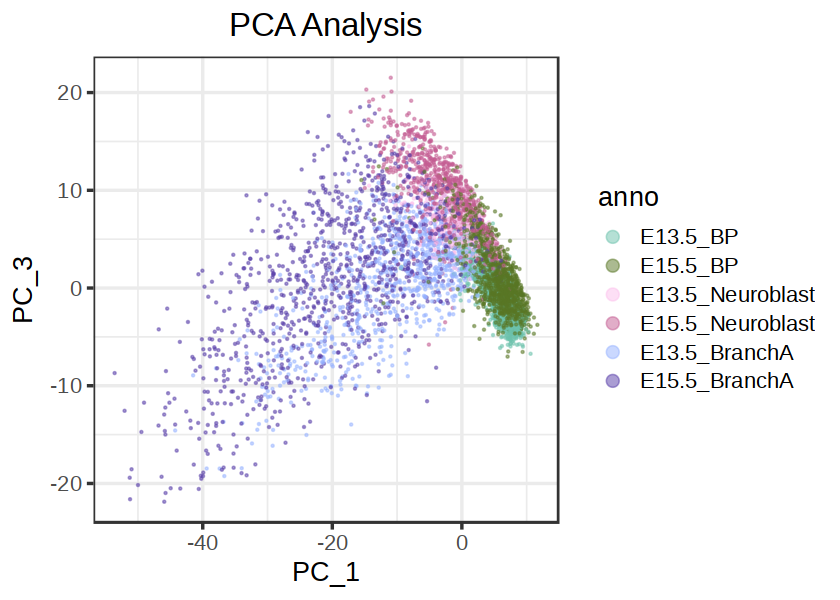

In [15]:
pca_embeddings <- obj@reductions$pca@cell.embeddings
pca_data <- as.data.frame(pca_embeddings)

colors <- c(
  "E13.5_Neuroblast" = "#fbc0ec",  
  "E15.5_Neuroblast" = "#c45d92",  
  "E13.5_BranchA" = "#96b1ff",  
  "E15.5_BranchA" = "#573ca7",
  "E13.5_BP" = "#6dc1ab",
  "E15.5_BP" = "#597724"
   )

pca_sdev <- obj@reductions$pca@stdev
total_variance <- sum(pca_sdev)
variance_explained <- (pca_sdev/ total_variance) * 100
pc1_var <- round(variance_explained[1], 2)
pc3_var <- round(variance_explained[3], 2)

pca_data$anno <- paste0(obj@meta.data$stage, "_",obj@meta.data$final.annotation)
pca_data$group <- obj@meta.data$group
pca_data$stage <- obj@meta.data$stage

pca_data$anno <- factor(pca_data$anno, levels = c('E13.5_BP','E15.5_BP','E13.5_Neuroblast','E15.5_Neuroblast','E13.5_BranchA','E15.5_BranchA'))


p <- ggplot(pca_data, aes(x = PC_1, y = PC_3, color = anno)) +
  geom_point(size = 0.2, alpha = 0.5) +
  labs(
      # x = paste0("PC_1 (", pc1_var, "%)"),
      #  y = paste0("PC_3 (", pc3_var, "%)"),
      
      x = paste0("PC_1"),
       y = paste0("PC_3"),
       title = "PCA Analysis") +
  theme_bw(base_size = 16) & 
    scale_color_manual(values = colors) & 
    theme(plot.title = element_text(hjust = 0.5)) & 
    guides(color = guide_legend(override.aes = list(size = 3)))

options(repr.plot.width = 7, repr.plot.height = 5)
print(p)



####

#### Slingshot

In [20]:
library(slingshot)
library(SingleCellExperiment)
library(Seurat)
sce <- as.SingleCellExperiment(obj, assay = "RNA") 
sce_ss <- slingshot(sce,      
                     reducedDim = obj@reductions$pca@cell.embeddings[,c(1,3)], 
                     clusterLabels = sce$final.annotation, 
                     start.clus = 'BP', 
                     end.clus = "BranchA",
                     approx_points = 150)
obj$pseudotime <- sce_ss@colData[colnames(obj), "slingPseudotime_1"]

saveRDS(obj@meta.data, file = "./outputdata/pseudotime_normalized.rds")

         
          E13.5 E15.5
  Control  1702  1702
  Vcl cKO  1702  1702

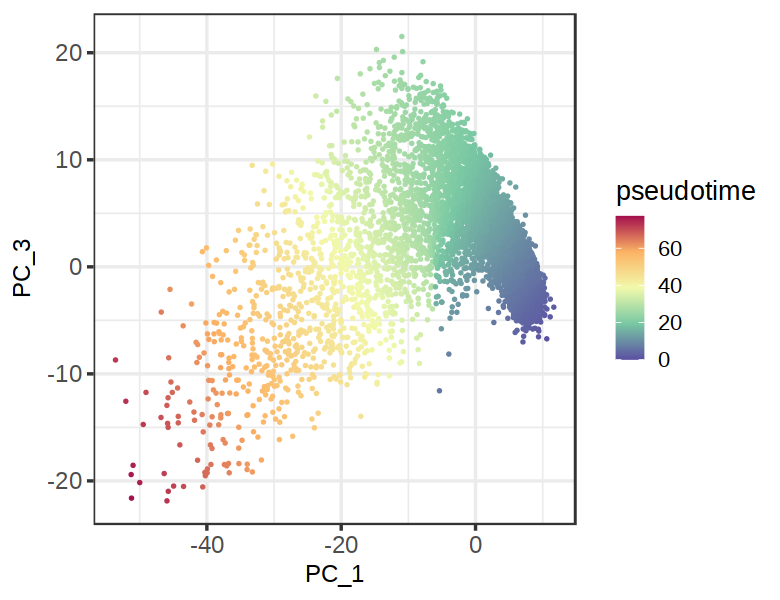

In [24]:
library(ggplot2)
meta <- reducedDim(sce_ss, type = "PCA", withDimnames = TRUE) %>% as.data.frame()
meta$pseudotime <- sce_ss@colData[rownames(meta), "slingPseudotime_1"]
meta$stage <- sce_ss@colData[rownames(meta), "stage"]
meta$group <- sce_ss@colData[rownames(meta), "group"]
meta$anno <- sce_ss@colData[rownames(meta), "final.annotation"]

table(meta$group, meta$stage) 

# meta <- meta %>% filter(pseudotime < 23)

options(repr.plot.width = 6.5, repr.plot.height = 5)
p <- ggplot(meta, aes(x = PC_1, y = PC_3, color = pseudotime)) + 
    geom_point(size = 0.5) + scale_color_gradientn(colours = c(colorRampPalette(c("#5b51a3","#79c9a4","#f2faac","#fdb465","#a4104d"))(90))) + 
    theme_bw(base_size = 16) + 
    theme(axis.text = element_text(size = 14), 
          axis.title =  element_text(size = 14), 
          strip.text = element_text(size = 14)) & 
    xlab("PC_1") &  ylab("PC_3"); print(p)


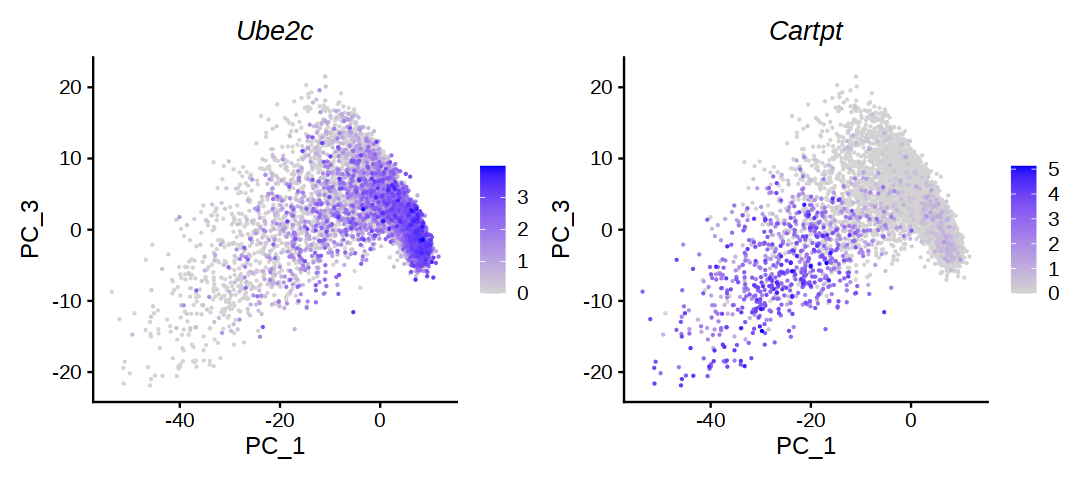

In [22]:
options(repr.plot.width = 9, repr.plot.height = 4)
dims <- c(1,3)
FeaturePlot(obj, features = c("Ube2c", "Cartpt"), reduction = "pca", dims = dims, pt.size = 0.001, order = T, ncol = 2) & theme(plot.title = element_text(face = "italic"))

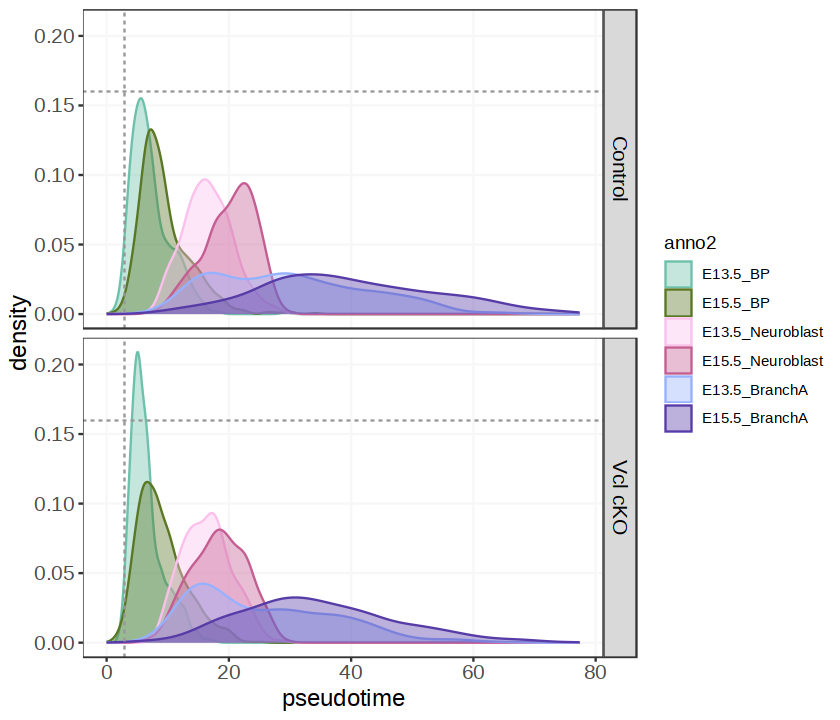

In [203]:

meta$anno2 <- paste0(meta$stage, "_", meta$anno)
meta$anno2 <- factor(meta$anno2, levels = c('E13.5_BP','E15.5_BP','E13.5_Neuroblast','E15.5_Neuroblast','E13.5_BranchA','E15.5_BranchA'))

colors <- c(
  "E13.5_Neuroblast" = "#fbc0ec",  
  "E15.5_Neuroblast" = "#c45d92",  
  "E13.5_BranchA" = "#96b1ff",  
  "E15.5_BranchA" = "#573ca7",
  "E13.5_BP" = "#6dc1ab",
  "E15.5_BP" = "#597724"
   )
options(repr.plot.width = 7, repr.plot.height = 6)
ggplot(meta, aes(x = pseudotime, fill = anno2, color = anno2)) + 
    geom_density(alpha = 0.4) + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors)+ 
    facet_grid(group~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
         panel.grid.major = element_line(color = "#f7f7f7"),
          # legend.position = "none",
    panel.grid.minor = element_line(color = "white")) & 
    geom_vline(xintercept = 3, linetype = "dashed", color = "#979797") &
    geom_hline(yintercept = 0.16, linetype = "dashed", color = "#979797")



pdf 
  2

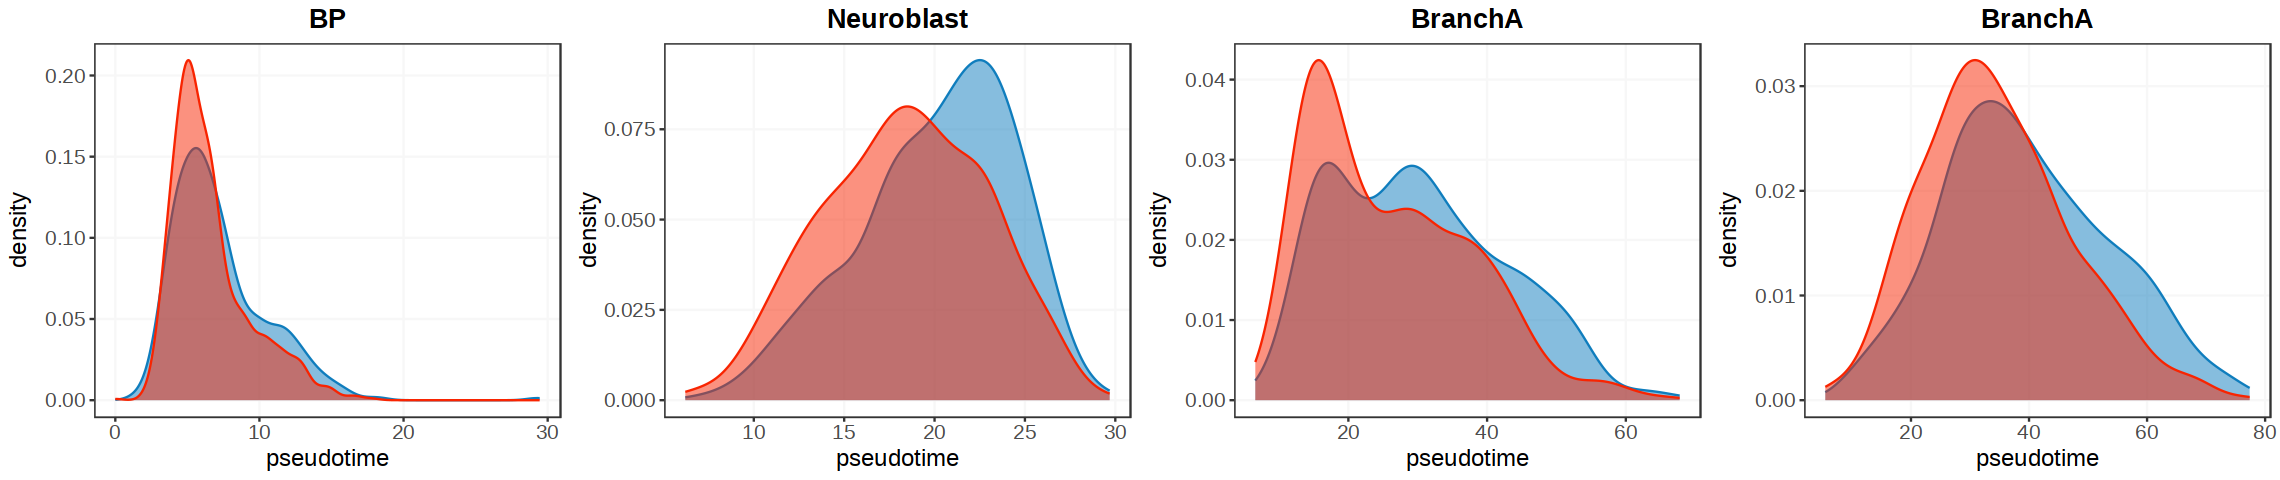

In [25]:

meta <- readRDS("./outputdata/pseudotime_normalized_con_ko.rds")

####### 

p1 <- ggplot(subset(meta, anno2 == "E13.5_BP"), aes(x = pseudotime, fill = group, color = group)) + geom_density(alpha = 0.5) + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    # facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
         panel.grid.major = element_line(color = "#f7f7f7"),
          legend.position = "none",
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 2.8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.21, linetype = "dashed", color = "#979797") & 
    ggtitle("BP")


p2 <- ggplot(subset(meta, anno2 == "E15.5_Neuroblast"), aes(x = pseudotime, fill = group, color = group)) + geom_density(alpha = 0.5) + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    # facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
         panel.grid.major = element_line(color = "#f7f7f7"),
          legend.position = "none",
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.1, linetype = "dashed", color = "#979797") & 
    ggtitle("Neuroblast")

p3 <- ggplot(subset(meta, anno2 == "E13.5_BranchA"), aes(x = pseudotime, fill = group, color = group))  + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    # facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
          legend.position = "none",
         panel.grid.major = element_line(color = "#f7f7f7"),
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.05, linetype = "dashed", color = "#979797") & 
    ggtitle("BranchA") & geom_density(alpha = 0.5)


p4 <- ggplot(subset(meta, anno2 == "E15.5_BranchA"), aes(x = pseudotime, fill = group, color = group))  + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    # facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
          legend.position = "none",
         panel.grid.major = element_line(color = "#f7f7f7"),
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.05, linetype = "dashed", color = "#979797") & 
    ggtitle("BranchA") & geom_density(alpha = 0.5)

pdf("./0_figure/Density_Pseudotime.pdf", height = 4, width = 18)
options(repr.plot.width = 19, repr.plot.height = 4)
library(cowplot)
cowplot::plot_grid(p1, p2, p3, p4, ncol = 4, align = "v", nrow = 1, rel_widths = c(1,1,1, 1))
dev.off()
cowplot::plot_grid(p1, p2, p3, p4, ncol = 4, align = "v", nrow = 1, rel_widths = c(1,1,1, 1))


pdf 
  2

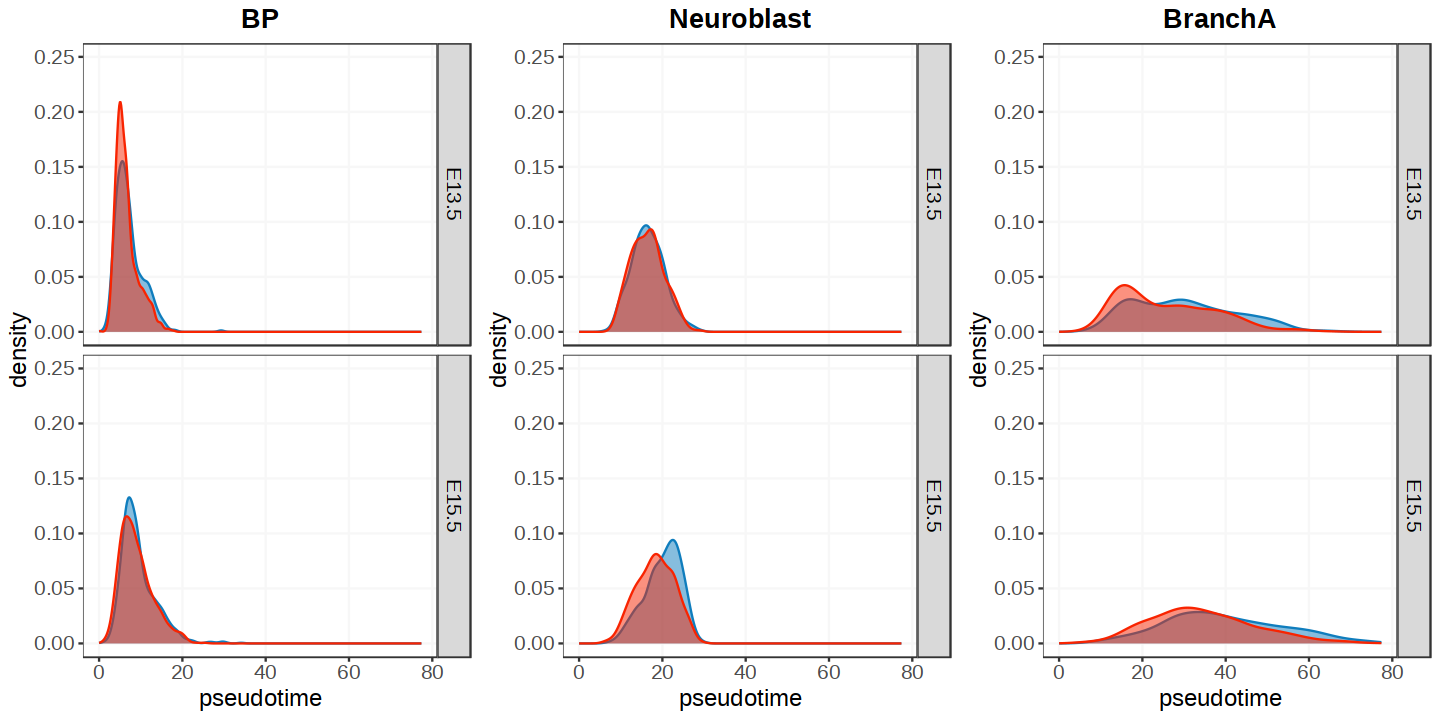

In [39]:

meta <- readRDS("./outputdata/pseudotime_normalized_con_ko.rds")

####### 

p1 <- ggplot(subset(meta, anno == "BP"), aes(x = pseudotime, fill = group, color = group)) + geom_density(alpha = 0.5) + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
         panel.grid.major = element_line(color = "#f7f7f7"),
          legend.position = "none",
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 2.8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.21, linetype = "dashed", color = "#979797") & 
    ggtitle("BP") & xlim(min(meta$pseudotime), max(meta$pseudotime))& ylim(0, 0.25)
  

p2 <- ggplot(subset(meta, anno == "Neuroblast"), aes(x = pseudotime, fill = group, color = group)) + geom_density(alpha = 0.5) + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
         panel.grid.major = element_line(color = "#f7f7f7"),
          legend.position = "none",
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.1, linetype = "dashed", color = "#979797") & 
    ggtitle("Neuroblast")& xlim(min(meta$pseudotime), max(meta$pseudotime))& ylim(0, 0.25)

p3 <- ggplot(subset(meta, anno == "BranchA"), aes(x = pseudotime, fill = group, color = group))  + 
    scale_fill_manual(values = colors) + 
    scale_color_manual(values = colors) + 
    facet_grid(stage ~.) & 
    theme_bw() & 
    theme(axis.text = element_text(size = 12),  
          axis.title =  element_text(size = 14),
          plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
         strip.text = element_text(size = 12, color = "black"), 
          legend.position = "none",
         panel.grid.major = element_line(color = "#f7f7f7"),
    panel.grid.minor = element_line(color = "white")) & 
    # geom_vline(xintercept = 8, linetype = "dashed", color = "#979797") & 
    # geom_hline(yintercept = 0.05, linetype = "dashed", color = "#979797") & 
    ggtitle("BranchA") & geom_density(alpha = 0.5) & xlim(min(meta$pseudotime), max(meta$pseudotime)) & ylim(0, 0.25)


pdf("./0_figure/Density_Pseudotime_control_mutant.pdf", height = 6, width = 12)
options(repr.plot.width = 12, repr.plot.height = 6)
library(cowplot)
cowplot::plot_grid(p1, p2, p3, ncol = 3, align = "v")
dev.off()
cowplot::plot_grid(p1, p2, p3, ncol = 3, align = "v")


In [28]:
results <- data.frame()
for(celltype in c("BP", "Neuroblast", "BranchA")){ 
    for(stag in c("E13.5","E15.5")){ 
        result <-  ks.test(subset(meta, anno == celltype & group == "Vcl cKO" & stage == stag)$pseudotime,
                       subset(meta, anno == celltype & group == "Control" & stage == stag)$pseudotime)
        temp <- data.frame("type" = celltype, 
                              "stage" = stag, 
                              "pval" = result$p.value, 
                              "method" = result$method,
                              "alternative" = result$alternative)
        results <- rbind(results, temp)
    }
}

library(rstatix)
results$adj.pval <- p.adjust(results$pval, "bonferroni")
results <- results %>% add_significance("adj.pval")
results

results$anno2 <- paste0(results$type, "_", results$stage)

Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(subset(meta, anno == celltype & group == "Vcl cKO" & :
“p-value will be approximate in the presence of ties”


type,stage,pval,method,alternative,adj.pval,adj.pval.signif
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
BP,E13.5,1.938951e-05,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,1.163370e-04,***
BP,E15.5,3.737965e-03,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,2.242779e-02,*
Neuroblast,E13.5,9.525096e-01,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,1.000000e+00,ns
Neuroblast,E15.5,1.697487e-07,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,1.018492e-06,****
BranchA,E13.5,7.408848e-06,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,4.445309e-05,****
BranchA,E15.5,8.371295e-06,Asymptotic two-sample Kolmogorov-Smirnov test,two-sided,5.022777e-05,****


In [ ]:
saveRDS(obj, file = "./outputdata/obj_normalized_con_ko_final.rds")

#### GO for DEGs

In [ ]:
library(dplyr)
library(foreach)
library(doParallel)
library(openxlsx)
library(clusterProfiler)
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)
source("./Functions.r")
i <- 1

num_cores <- 5  # Use all but one core
registerDoParallel(cores = num_cores)

datalist <- data.frame("stage" = c("E13.5","E15.5", "E13.5", "E15.5"), 
                      "celltype" = c("BP","Neuroblast", "BranchA", "BranchA"), 
                      "min" = c(2, 8, 10, 10), 
                      "max" = c(15, 28, 55, 70), 
                      "Kval" = c(5, 5, 5, 4)) 

go.genes <- foreach(i = 1:nrow(datalist), .packages = c("openxlsx", "AnnotationDbi", "dplyr", "org.Mm.eg.db", "clusterProfiler")) %dopar% {
    name <- paste0(datalist[i, "stage"], "_", datalist[i, "celltype"])
    degs <- readRDS(paste0("./tradseq_output/3. monocles_DEGs_", name, ".rds"))
    degs <- degs %>% filter(qval < 0.05 & bcg.pct > 0.1)
    degs$gene <- rownames(degs)
    
    genes <- list("up" = degs[degs$log2FC_mean > 0, "gene"], 
                 "down" = degs[degs$log2FC_mean < 0, "gene"])

    print(paste0(name, " up:", length(genes[[1]])))
    print(paste0(name, " down:", length(genes[[2]])))
 
    unlist(genes)
}
names(go.genes) <- paste0(datalist$stage, "_", datalist$celltype)


result <- compareCluster(
    geneCluster = go.genes,
    fun = "enrichGO",
    OrgDb = org.Mm.eg.db,
    ont = "BP",  
    keyType = "SYMBOL",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05,
    readable = TRUE) 

all.result <- result@compareClusterResult

wb <- createWorkbook()
for(name in unique(all.result$Cluster)){ 
    go_result <- subset(all.result, Cluster == name)
    addWorksheet(wb, sheetName = name)
    temp <- go_result[go_result$Cluster == name,] %>% arrange(desc(Count))
    writeData(wb, sheet =  name, x = temp)
}

saveRDS(all.result, file = "GO_degs_4stages.rds")
saveWorkbook(wb = wb, file = "GO_degs_4stages.xlsx", overwrite = T)

#### Go for Branch A and neuroblast

In [ ]:
library(dplyr)
library(foreach)
library(doParallel)
library(openxlsx)
library(clusterProfiler)
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)
source("./Functions.r")
i <- 1

In [12]:
deg1 <- readRDS("/tradseq_output/3. monocles_DEGs_E15.5_Neuroblast.rds")
deg2 <- readRDS("/tradseq_output/3. monocles_DEGs_BranchA.rds")

deg1 <- deg1 %>% filter(qval < 0.05 & bcg.pct > 0.1)
deg1$gene <- rownames(deg1)

deg2 <- deg2 %>% filter(qval < 0.05 & bcg.pct > 0.1)
deg2$gene <- rownames(deg2)

genes <- list("up" = c(deg1[deg1$log2FC_mean > 0, "gene"],
                       deg2[deg2$log2FC_mean > 0, "gene"] %>% unique()), 
             "down" = c(deg1[deg1$log2FC_mean < 0, "gene"],
                        deg2[deg2$log2FC_mean < 0, "gene"]) %>% unique())


In [79]:
for(name in names(genes)){ 
    genes[[name]] <- AnnotationDbi::select(org.Mm.eg.db, 
                                           keys = genes[[name]], 
                                           columns = c("SYMBOL", "GENENAME", "ENTREZID"), 
                                           keytype = "SYMBOL")$ENTREZID %>% na.omit()

}
result <- compareCluster(
    geneCluster = genes,
    fun = "enrichKEGG",
    organism = "mmu",
    # keyType = "ENTREZID",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05) 
result <- setReadable(result, OrgDb = org.Mm.eg.db, keyType = "ENTREZID")
all.result <- result@compareClusterResult
plot.data <- all.result %>% 
    group_by(Cluster) %>% 
    filter(p.adjust < 0.01) %>% 
    arrange(desc(Count)) %>% 
    slice_max(order_by = Count, n = 10)


In [25]:
library(ggplot2)
descrip <- gsub(pattern = " - Mus musculus \\(house mouse\\)", replacement = "", plot.data$Description)
plot.data$descrip <- paste0(descrip, "-", plot.data$ID)

terms <- c("MAPK signaling pathway-mmu04010", "Axon guidance-mmu04360", "Rap1 signaling pathway-mmu04015", "Alzheimer disease-mmu05010", "Pathways of neurodegeneration - multiple diseases-mmu05022")

plot.data2 <- subset(plot.data, descrip %in% terms)  %>% as.data.frame()
plot.data2[1,"descrip"] <- "Pathways of neurodegeneration-mmu05022"

plot.data2$descrip <- factor(plot.data2$descrip, levels = unique(plot.data2$descrip) )

pdf("./0_figure/KEGG_BranchA_Neuroblast.pdf", height = 4, width = 7)
options(repr.plot.width = 6, repr.plot.height = 4)
p <- dotplt.enriched(plot.data2, 
                x = "Cluster", y = "descrip", 
                size = "Count", color = "p.adjust", 
                title = "KEGG for Neuroblast & BranchA") & ylab(NULL)

print(p)
dev.off()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


pdf 
  2

In [95]:
wb <- createWorkbook()
for(name in unique(all.result$Cluster)){ 
    go_result <- subset(all.result, Cluster == name)
    addWorksheet(wb, sheetName = name)
    temp <- go_result[go_result$Cluster == name,] %>% arrange(desc(Count) )%>% filter(p.adjust < 0.01) 
    writeData(wb, sheet =  name, x = temp)
}

# saveRDS(all.result, file = "GO_results_Neuroblast&BranchA.rds")
saveWorkbook(wb = wb, file = "GO_results_Neuroblast&BranchA.xlsx", overwrite = T)


### AUC pathway score for pathways

In [103]:
##############################
library(openxlsx)
library(dplyr)
library(foreach)
library(doParallel)
library(AUCell)
library(ggpubr)
library(Seurat)
library(ggplot2)
library(tidyr)
library(dplyr)
packages <- c("AUCell", "Seurat", "dplyr")
registerDoParallel(cores = 5)
set.seed(2025)

setwd("./5_neuronBranch/")

datalist <- data.frame("stage" = c("E13.5","E15.5", "E13.5", "E15.5"), 
                      "celltype" = c("BP","Neuroblast", "BranchA", "BranchA"))
datalist$name <- paste0(datalist$stage, "_", datalist$celltype)

obj <- readRDS("./outputdata/obj_normalized_con_ko_final.rds")
obj$anno2 <- paste0(obj$stage, "_", obj$final.annotation) 


####################### caculate pathway score genes involved in pathways
path_genes <- readRDS("./Top50_pathway_genes.rds")

name <- datalist$name[1]
i <- names(path_genes[[name]])[1]
path.scores <- list()
test.scores <- list()
name <- datalist$name[1]

for(name in datalist$name){ 
 
    obj.temp <- subset(obj, anno2 == name)
    count.mat <- GetAssayData(object = obj.temp, 
                              layer = "counts", 
                              assay = "RNA")
    
    ######## 1. calculate the pathway score, save as dataframe
    cells.rankings <- AUCell_buildRankings(count.mat, plotStats = FALSE)

    path.score <- foreach(i = names(path_genes[[name]]),
                           .combine = "cbind",
                           .packages = packages) %dopar% { 
        
                genes <- intersect(path_genes[[name]][[i]], rownames(count.mat))
                cells_AUC <- AUCell_calcAUC(list("geneset" = genes), cells.rankings)
                auc.mat <- getAUC(cells_AUC) %>% t()
                colnames(auc.mat) <- paste0(i, "_", length(path_genes[[name]][[i]]), "_genes")
                auc.mat

        }
    
    path.scores[[name]] <- path.score

    ######## 2.statistics test: identify the significantly changed pathways
    cells_con <- subset(obj.temp@meta.data, group == "Control") %>% rownames()
    cells_ko <- subset(obj.temp@meta.data, group == "Vcl cKO") %>% rownames()
    test.score <- foreach(i = colnames(path.score),
                       .combine = "rbind",
                       .packages = packages) %dopar% { 
        res <- wilcox.test(x = path.score[cells_con,i],
                           y = path.score[cells_ko,i],
                           paired = F)
        
        res.data <- data.frame("name" = name,
                               "Mean_Pathway_Score_Control" = mean(path.score[cells_con,i]),
                               "Mean_Pathway_Score_Vcl_cKO" = mean(path.score[cells_ko,i]),    
                               "meanfc" = mean(path.score[cells_ko,i])/mean(path.score[cells_con,i]),
                               "pval" = res$p.value,
                               "test" = "wilcox.test",
                               "method" = "two.sided",
                               "path" = i,
                        
                               )       
    }
    test.score$log2meanfc <- log2(test.score$meanfc)
    test.scores[[name]] <- test.score
}    

saveRDS(path.scores, file = "Top50_pathway_score.rds")
saveRDS(test.scores, file = "Top50_pathway_score_test.rds")

stopImplicitCluster()

#### filter the pathways 

In [2]:
library(dplyr)

test.scores <- readRDS("./pathwayscore/Top50_pathway_score_test.rds")
path.scores <- readRDS("./pathwayscore/Top50_pathway_score.rds")

results <- data.frame()
for(type in unique(test.scores$name)){ 
    temp.down <- test.scores[test.scores$name == type, ] %>% 
        filter(pval < 0.05)  %>% 
        arrange(desc(abs(log2meanfc))) %>% head(n = 10) 
    results <- rbind(results, temp.down)

}
unique(results$term) %>% length()

[1] 7

In [105]:
library(openxlsx)
wb <- createWorkbook()

test.scores$gene_num <- unlist(lapply(test.scores$path, function(x){unlist(strsplit(x, split = "_"))[2]}))

temp.data <- test.scores[,c("name", "term", "log2meanfc", "Mean_Pathway_Score_Control", "Mean_Pathway_Score_Vcl_cKO", "gene_num", "pval", "test", "method", "pathID")]

temp.data$abs_log2meanfc <- abs(temp.data$log2meanfc)

results <- test.scores
for(n in unique(temp.data$name)){ 
    temp <- subset(temp.data, results$name == n)
    addWorksheet(wb = wb, sheetName = paste0(n))
    writeData(x = temp, wb = wb, sheet = paste0(n))
}
saveWorkbook(wb, file = "3.Top50_All_Disrupted_pathway_score.xlsx", overwrite = T)

#### TF-target inference

In [ ]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(SCopeLoomR)

objs.sub <- readRDS(paste0("./outputdata/obj_normalized_con_ko_final.rds"))
objs.sub$anno2 <- paste0(objs.sub$stage,"_", objs.sub$final.annotation)
table(objs.sub$stage, objs.sub$final.annotation)
table(objs.sub$group, objs.sub$stage)

objs.sub <- NormalizeData(objs.sub)

test.scores <- readRDS("./Top50_pathway_score_test.rds")
all.result <- readRDS("./GO_degs_4stages.rds")

####### Top 10 pathways
results <- data.frame()
degs <- list()
for(type in unique(test.scores$name)){ 
    temp <- test.scores[test.scores$name == type, ] %>% 
        filter(pval < 0.05)  %>% 
        arrange(desc(abs(log2meanfc))) %>% head(n = 10) 
    data.sub <- all.result %>% filter(Cluster == type & Description %in% temp$term)
    degs[[type]] <- unlist(strsplit(data.sub$geneID, split = "/"))
    results <- rbind(results, data.sub)
}

name <- "all"
# for(name in unique(objs.sub$final.annotation)){ 
    cells <- subset(objs.sub@meta.data,  anno2 %in% type) %>% rownames()

    raw.mat <- GetAssayData(objs.sub[,cells], layer = "counts", assay = "RNA")[unique(unlist(degs)),]
    
    exprMat_filtered <- raw.mat
    loom <- SCopeLoomR::build_loom(
      file.name = paste0("./SCENIC/",name ,".loom"),
      dgem = exprMat_filtered,
      default.embedding = NULL  
    )
# }

#### pyscenic (bash)


conda activate /pyscenic

path="./"
cd ${path}

ref_tf="/SCENIC/allTFs_mm.txt"

ref_feather="/cisTarget_databases/mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather" 
ref_tbl="/SCENIC/motifs-v9-nr.mgi-m0.001-o0.0.tbl"

name="all"
pyscenic grn \
--seed 2015 \
--num_workers 3 \
--output ./SCENIC/${name}_adj.tsv \
--method grnboost2 \
./SCENIC/${name}-Copy1.loom \
${ref_tf}


pyscenic ctx \
./SCENIC/${name}_adj.tsv \
${ref_feather} \
--annotations_fname ${ref_tbl} \
--expression_mtx_fname ./SCENIC/${name}-Copy1.loom \
--output ./SCENIC/${name}_reg.csv \
--num_workers 3 

pyscenic aucell \
./SCENIC/${name}-Copy1.loom \
./SCENIC/${name}_reg.csv \
-o ./${name}_auc_mtx.csv \
--num_workers 3  
  

pyscenic ctx \
./SCENIC/${name}_adj.tsv \
${ref_feather} \
--annotations_fname ${ref_tbl} \
--expression_mtx_fname ./SCENIC/${name}-Copy1.loom \
--output ./SCENIC/${name}_reg.gmt \
--num_workers 3



#### expression/regulon activity along trajectory

In [ ]:
library(ggpubr)
library(Seurat)
objs.sub <- readRDS(paste0("../outputdata/obj_normalized_con_ko_final.rds")) 

tfs <- c("Klf7","E2f1","Egr1")
mat <- t(GetAssayData(objs.sub, layer = "data")[tfs,]) 

# tfs <- paste0(tfs, "(+)")
# mat <- t(auc) 

meta <- cbind(mat, objs.sub@meta.data[rownames(mat),])[colnames(auc),]
meta$pseudotime <- pse[rownames(meta), "pseudotime"]

meta <- meta[meta$pseudotime > 3 & meta$pseudotime < 50,]

pdf("./0_figure/Regulon_tfs_trajectory.pdf", height = 4, width = 5)
options(repr.plot.width = 6, repr.plot.height = 4)

for(i in tfs[1:3]){
    p <- ggplot(meta, aes(x = pseudotime, y = .data[[i]], color = group)) + 
        geom_point(size = 1, alpha = 0.2, aes(color = final.annotation, shape = group)) + 
        geom_smooth(method = "loess", se = TRUE, size = 0.1) + 
        scale_color_manual(values = c("Vcl cKO"="#f82401", 
                                      "Control" = "#0f7dbd",     
                                      "BP" = "#6b853e",
                                      "Neuroblast" = "#fdcee6",
                                      "BranchA" = "#bca9f5")) + 
        theme_bw() + 
        # facet_grid(.~group) + 
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16), 
              plot.title = element_text(size = 16, 
                                        hjust = 0.5, face = "bold"),
              legend.position = "none",
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 14), 
              strip.text = element_text(size = 14, face = "bold")
    ) + 
        ylab(paste0("Regulon activity"))& 
        # ylab(paste0("Log2 Expression"))& 
    
    ggtitle(i)
    print(p)
}
dev.off()

library(ggpubr)
library(Seurat)
tfs <- c("Klf7","E2f1","Egr1")
mat <- t(GetAssayData(objs.sub, layer = "data")[tfs,]) 

options(repr.plot.width = 7, repr.plot.height = 4)
meta$final.annotation <- factor(meta$final.annotation, levels = c("BP","Neuroblast","BranchA"))

pdf("./0_figure/VlnPlot_Expression_tfs.pdf", height = 4, width = 8)
for(i in tfs){ 
    p <- ggplot(meta[colnames(auc),], 
            aes(x = group, y = .data[[i]], fill = group))& 
    geom_violin(trim = F) & 
    stat_summary(fun = mean, 
                 geom = "crossbar", 
                 width = 0.3, 
                 size = 0.5, 
                 color = "black") &
    stat_compare_means(method = "wilcox.test", 
                        aes(group = group), 
                        label = "p.signif", 
                        label.x = 1.5) & 
    facet_grid(.~final.annotation) &
    theme_bw(base_size = 18) & 
    theme(plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.text.x = element_blank(),
          axis.ticks.length.x = unit(0, "cm"),
          legend.position = "none")& 
    xlab(NULL) & 
    ylab("log2 Expression") & ggtitle(i) &
    scale_fill_manual(values = c("Vcl cKO"="#f82401", "Control" = "#0f7dbd"))
    
    print(p)

}
dev.off()

#### GO for modules

In [ ]:
source("/my_functions.R")
genes <- readRDS("all_Tfs.rds")
length(unique(unlist(genes)))
temp <- list("Klf7" = setdiff(genes[[1]],c(genes[[2]], genes[[3]])),
             "Egr1" = setdiff(genes[[2]],c(genes[[1]], genes[[3]])),
             "E2f1" = setdiff(genes[[3]],c(genes[[1]], genes[[2]])),
             "Egr1_Klf7" = intersect(genes[[1]],genes[[2]]),
             "Egr1_E2f1" = intersect(genes[[2]],genes[[3]])
            )


temp <- list("Module4" = setdiff(genes[[1]],c(genes[[2]], genes[[3]])),
             "Module2" = setdiff(genes[[2]],c(genes[[1]], genes[[3]])),
             "Module3" = intersect(genes[[1]],genes[[2]]),
             "Module1" = intersect(genes[[2]],genes[[3]])
            )

result <- compareCluster(
    geneCluster = temp,
    fun = "enrichGO",
    OrgDb = org.Mm.eg.db,
    ont = "BP",  
    keyType = "SYMBOL",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05,
    readable = TRUE) 

all.result <- result@compareClusterResult

all.result$descrip <- paste0(all.result$Description, "-", all.result$ID)
# saveRDS(temp, file = "Targets.list.network.rds")

In [ ]:
library(ggplot2)
plot.data <- plot.data %>%
  mutate(
    ycolor = case_when(
      Cluster == "Module1" ~ "#CED8F6", 
      Cluster == "Module2" ~ "#dbde74", 
      Cluster == "Module3" ~ "#faac58",    
      Cluster == "Module4" ~ "#CED8F6"
    )
  ) 

plot.data <- plot.data %>% arrange(desc(Cluster))
plot.data$Cluster <- factor(plot.data$Cluster, levels = paste0("Module", 1:4))

plot.data$descrip <- factor(plot.data$descrip, c("regulation of neurogenesis-GO:0050767", "cell junction assembly-GO:0034329", "developmental growth involved in morphogenesis-GO:0060560", "regulation of cellular component size-GO:0032535", "actin filament organization-GO:0007015", "vesicle-mediated transport in synapse-GO:0099003", "synaptic vesicle cycle-GO:0099504")) 

options(repr.plot.width = 9, repr.plot.height = 4)

p <- dotplt.enriched(data = plot.data, x = "Cluster", y = "descrip",size = "Count",color = "p.adjust", title = "Top 2 Go for module genes") + ylab("")
ggsave(p, file = "./0_figure/Top 2 Go for module genes.png", height = 4, width = 9)
print(p)

#### Network 

In [ ]:
library(igraph)
library(ggraph)
library(dplyr)

############ correlation of vcl and module genes
temp <- readRDS("corr.Vcl.rds")
plot.data <- do.call(rbind,temp) %>% filter(Pvalue < 0.05)
plot.data <- plot.data[-which(plot.data$gene2 == "Vcl"),]
plot.data$module <- ifelse(plot.data$module == "background", "Background", plot.data$module)
dim(plot.data)

rownames(plot.data) <- NULL

plot.data <- plot.data[-which(duplicated(plot.data)),]
plot.data3 <- subset(plot.data, plot.data$module != "Background") %>% arrange(desc(correlation))
plot.data3$rank <- 1:nrow(plot.data3)

plot.data3$lable <- ifelse(plot.data3$rank %in% 1:10, plot.data3$gene2, NA)



############ TF targets
genes <- readRDS("all_Tfs.rds")
length(unique(unlist(genes)))

node1 <- c(rep(names(genes)[1], times = length(genes[[names(genes)[1]]])), 
                 rep(names(genes)[2], times = length(genes[[names(genes)[2]]])), 
                 rep(names(genes)[3], times = length(genes[[names(genes)[3]]]))
                )
type <- c(rep(names(genes)[1], times = length(genes[[names(genes)[1]]])), 
                 rep(names(genes)[2], times = length(genes[[names(genes)[2]]])), 
                 rep(names(genes)[3], times = length(genes[[names(genes)[3]]]))
                )
node2 <- c(genes[[names(genes)[1]]], genes[[names(genes)[2]]], genes[[names(genes)[3]]])


temp <- list("Klf7" = setdiff(genes[[1]],c(genes[[2]], genes[[3]])),
             "Egr1" = setdiff(genes[[2]],c(genes[[1]], genes[[3]])),
             "E2f1" = setdiff(genes[[3]],c(genes[[1]], genes[[2]])),
             "Egr1_Klf7" = intersect(genes[[1]],genes[[2]]),
             "Egr1_E2f1" = intersect(genes[[2]],genes[[3]])
            )


pp <- read.csv("./string_interactions_short_experimental_database.csv")
# pp.edges <- data.frame(
#         from = pp$node2,
#         to = pp$'X.node1',
#         type = "pp"
#     )
pp.edges <- data.frame(
        from = pp$node2,
        to = pp$node1,
        type = "pp"
    )

pp.edges <- subset(pp.edges, pp.edges$from %in% "Vcl"|pp.edges$to %in% "Vcl")
dim(pp.edges)

# intersect(pp.edges$to, unique(plot.data3$lable))


adddata <- data.frame("from" = rep("Vcl", 10), "to" = na.omit(unique(plot.data3$lable)), "type" = rep("corr", 10))

edges <- data.frame(
        from = node1,
        to = node2,
        type = type
    )

edges <- rbind(edges, pp.edges)
edges <- rbind(edges, adddata)

gene_large <- unique(c(unique(adddata$to), unique(pp.edges$to)))

node <- unique(c(node1, node2))
nodes <- data.frame(
  name = node,
  group = dplyr::case_when(
    node == "Vcl" ~ "Vcl",  
    node == "Klf7" ~ "Klf7",  
    node == "Egr1" ~ "Egr1",  
    node == "E2f1" ~ "E2f1",  
    node %in% temp[["Klf7"]] ~ "Klf7",
    node %in% temp[["Egr1"]] ~ "Egr1",
    node %in% temp[["E2f1"]] ~ "genes",
    node %in% temp[["Egr1_Klf7"]] ~ "Egr1_Klf7",
    node %in% temp[["Egr1_E2f1"]] ~ "Egr1_E2f1",
      
    TRUE ~ "genes"
  )
)


# edges <- edges[edges$from %in% unlist(temp) & edges$to %in% unlist(temp),]
# nodes <- nodes[nodes$name %in% unlist(temp),]

# genes.rm <- setdiff(temp[["E2f1"]], "E2f1")
# edges <- edges[-which(edges$from %in% genes.rm | edges$to %in% genes.rm),]
# nodes <- nodes[-which(nodes$name %in% genes.rm),]

graph <- graph_from_data_frame(edges, vertices = nodes)
V(graph)$label <- as.character(1:vcount(graph)) 

colors <- c( "genes" = "#E6E6E6", 
            "E2f1" = "#a9a9f5", 
            "Klf7" = "#cadfde", 
            "Egr1" = "#dbde74", 
                        
            "Egr1_Klf7" = "#faac58", 
            "Egr1_E2f1" = "#CED8F6",
            "Vcl" = "#F781BE",
            "pp" = "red", 
            "corr" = "#2e64fe"

           )

options(repr.plot.width = 10, repr.plot.height = 7)
set.seed = 2025

p <- ggraph(graph, layout = "stress") +  
  geom_edge_link(aes(color = type), 
                 arrow = arrow(length = unit(1, "mm")), 
                 # color = "#cecece", 
                 # width = ifelse(E(graph)$type == "pp", 1.2, 0.6),
                 edge_alpha = 0.3
                )+
    scale_edge_colour_manual(values = colors)  +
  geom_node_point(aes(color = group), 
                  size = 6.5, 
                  alpha = ifelse(V(graph)$name %in% c(names(temp), gene_large), 1, 0.5)) + 
  geom_node_text(aes(label = name),
                 size = ifelse(V(graph)$name %in% c(names(temp), "Vcl"),2, 
                               ifelse(V(graph)$name %in% gene_large, 2, 1)),
                 check_overlap = F, 
                 face =  ifelse(V(graph)$name %in% c(names(temp), gene_large), "bold", "plain"),
                 nudge_x = 0, 
                 nudge_y = 0,
                 color = ifelse(V(graph)$name %in% gene_large, "#4374fe", "black")
                ) + 
  scale_color_manual(values = colors) +
  scale_fill_manual(values = colors) +

  theme_void()  +
  theme(legend.position = "right")
print(p) 

# pdf("TF-target-network_temp.pdf", height = 6, width = 9)
# print(p)
# dev.off()
